### 1. Import Required Libraries and Read in Data


#### 1.1 Import necessary libraries 

In [65]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from deepchem import metrics

#### 1.2 Read in the BBB dataset from Adenot paper

In [43]:
bbbneg = pd.read_csv("Adenot_BBB-.csv", names=['Drug', 'SMILES'])
bbbneg['permeable'] = np.zeros(len(bbbneg))
bbbneg

,Drug,SMILES,permeable
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0
...,...,...,...
350,KETOCONAZOLE,CC(=O)N1CCN(CC1)c1ccc(cc1)OCC1CO[C@@](Cn2ccnc2...,0.0
351,SPIRAMYCIN,CO[C@H]1[C@H](O)CC(=O)O[C@H](C)CC=CC=C[C@H](OC...,0.0
352,TEICOPLANIN,COC(=O)C1NC(=O)[C@H]2NC(=O)[C@H](NC(=O)[C@@H]3...,0.0
353,TERFENADINE,CC(C)(C)c1ccc(cc1)C(O)CCCN1CCC(CC1)C(O)(c1cccc...,0.0


In [44]:
bbbpos = pd.read_csv("Adenot_BBB+.csv", names=['Drug', 'SMILES'])
bbbpos['permeable'] = np.ones(len(bbbpos))
bbbpos

,Drug,SMILES,permeable
0,ADENOSYL-METHIONINE,C[S+](CC[C@H](N)C([O-])=O)C[C@H]1O[C@H]([C@H](...,1.0
1,ACEGLUTAMIDE,CC(=O)N[C@@H](CCC(N)=O)C(O)=O,1.0
2,ATROMEPINE,CN1C2CCC1CC(C2)OC(=O)C(C)(CO)c1ccccc1,1.0
3,ATROPINE,CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)c1ccccc1,1.0
4,BENZATROPINE,CN1[C@H]2CC[C@@H]1CC(C2)OC(c1ccccc1)c1ccccc1,1.0
...,...,...,...
1332,AMITRIPTYLINE,CN(C)CCC=C1c2ccccc2CCc2ccccc12,1.0
1333,CHLORPROMAZINE,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)Cl,1.0
1334,DISULFIRAM,CCN(CC)C(=S)SSC(=S)N(CC)CC,1.0
1335,MORPHINE,CN1CC[C@@]23[C@H]4Oc5c(ccc(c52)C[C@@H]1[C@@H]3...,1.0


### 2. Data Preprocessing

In [45]:
bbb_df = pd.concat([bbbneg, bbbpos])
print(bbb_df.shape)
bbb_df.reset_index(inplace=True, drop=True)

(1692, 3)


In [46]:
bbb_df['SMILES'][5]

'COc1ccc(cc1)CCN1CCC(CC1)Nc1nc2ccccc2n1Cc1ccc(cc1)F'

In [47]:
clean_smiles = []

for i in range(len(bbb_df['SMILES'])):
  clean = max(str(bbb_df['SMILES'][i]).split("."), key = len) # split the smiles by ".", and keep the longest substring
  clean_smiles.append(clean)
  
bbb_df['SMILES'] = clean_smiles

In [48]:
updated_smiles = bbb_df["SMILES"]
updated_count = 0

for i in range(len(updated_smiles)):
  if "." in updated_smiles[i]:
    updated_count += 1
print("After cleaning there is {} molecule with salts in their smiles.".format(updated_count))

After cleaning there is 0 molecule with salts in their smiles.


In [49]:
#delete missing data
print('Number of NA: ', bbb_df[['Drug', 'SMILES', 'permeable']].isna().sum())
bbb_df.dropna(subset = ['Drug', 'SMILES', 'permeable'])
print(bbb_df.shape)

Number of NA:  Drug         0
SMILES       0
permeable    0
dtype: int64
(1692, 3)


In [50]:
#multiple components
multiple_components = [smile for smile in bbb_df['SMILES'] if '.' in smile]
print('Number with Multiple Components: ', len(multiple_components))

Number with Multiple Components:  0


In [51]:
#remove duplicates
print('There are {} duplicates in BBB dataset.'.format(sum(bbb_df.duplicated('SMILES'))))
bbb_df.drop_duplicates(subset='SMILES', keep = 'first', inplace = True, ignore_index=True)
bbb_df.reset_index(drop = True, inplace = True)
print('After cleaning, there are {} duplicates left in BBB dataset.'.format(sum(bbb_df.duplicated('SMILES'))))

There are 20 duplicates in BBB dataset.
After cleaning, there are 0 duplicates left in BBB dataset.


In [52]:
bbb_df['permeable'] = bbb_df['permeable'].astype(int)

In [53]:
bbb_df.to_csv(r'adenot.csv', index=False)

#### 2.1 Molecule encoding

use the Morgan Fingerprints (radius = 2, nBits = 1024) as our molecular descriptors

In [54]:
r = 2
d = 1024

fp_list = []
mol_list = []
for smile in bbb_df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        print('invalid mol')
        bbb_df = bbb_df[bbb_df.SMILES != smile]
    else: 
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,r,nBits=d,useChirality=False)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fp_list.append(arr)
        mol_list.append(mol)

fp_df = pd.DataFrame(fp_list)
morgan_list = np.array(fp_list)
bbb_df = pd.concat([bbb_df, fp_df], axis=1)
#bbb_df['molecule'] = mol_list
print(morgan_list.shape)
print(bbb_df.shape)
bbb_df

[12:40:04] SMILES Parse Error: syntax error while parsing: CO[C@]1(NC(=O)CSC[C@@H]([N+H3])C([O-])=O)[C@H]2SCC(=C(N2C1=O)C(O)=O)CSc1nnnn1C
[12:40:04] SMILES Parse Error: Failed parsing SMILES 'CO[C@]1(NC(=O)CSC[C@@H]([N+H3])C([O-])=O)[C@H]2SCC(=C(N2C1=O)C(O)=O)CSc1nnnn1C' for input: 'CO[C@]1(NC(=O)CSC[C@@H]([N+H3])C([O-])=O)[C@H]2SCC(=C(N2C1=O)C(O)=O)CSc1nnnn1C'


invalid mol


[12:40:05] SMILES Parse Error: syntax error while parsing: nan
[12:40:05] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'


invalid mol
(1670, 1024)
(1672, 1027)


,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669,DISULFIRAM,CCN(CC)C(=S)SSC(=S)N(CC)CC,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1670,MORPHINE,CN1CC[C@@]23[C@H]4Oc5c(ccc(c52)C[C@@H]1[C@@H]3...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1671,TRIFLUOPERAZINE,CN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [57]:
#delete missing data after obtaining fingerprints
print('Number of NA: ', bbb_df.isna().sum())
bbb_df = bbb_df.dropna()
print(bbb_df.shape)

Number of NA:  Drug         2
SMILES       2
permeable    2
0            2
1            2
            ..
1019         2
1020         2
1021         2
1022         2
1023         2
Length: 1027, dtype: int64
(1668, 1027)


In [58]:
bbb_df.iloc[:, 3:]

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1666,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [59]:
# calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
# columns = calc.GetDescriptorNames()
# descriptors = []
# for mol in bbb_df['molecule']:
#     ds = calc.CalcDescriptors(mol)
#     descriptors.append(list(ds))

# descriptors_df = pd.DataFrame(descriptors)
 
# # specifying column names
# descriptors_df.columns = columns 

# bbb_df = pd.concat([bbb_df, descriptors_df], axis=1)

In [60]:
# bbb_df.dropna(inplace=True)
# #bbb_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# bbb_df = bbb_df[np.isfinite(bbb_df).all(1)]

In [61]:
# bbb_df

In [62]:
# Please write your code below:
X = bbb_df.iloc[:,3:].copy()
y = bbb_df.iloc[:,2].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [63]:
type(X_train)

pandas.core.frame.DataFrame

### 3. Construct Decision Tree ML Model

In [101]:
# Create a Decision Tree classifier object
dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, random_state=0)

# Train Decision Tree classifier
dt = dt.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = dt.predict(X_test)

# Calculate how often the classifier is correct
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred))
print("Precision Score:", metrics.precision_score(y_test, y_pred))
print("Recall Score:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.9241516966067864
Balanced Accuracy: 0.8550374064837905
ROC AUC: 0.8550374064837905
Precision Score: 0.9373493975903614
Recall Score: 0.970074812967581


## 4. Prediction Chemical Space Visualization

In [73]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [74]:
dim = 100
pca = PCA(n_components=dim)
components = pca.fit_transform(X_test)

In [75]:
tsne = TSNE(n_components=2)
t_components = tsne.fit_transform(components)

C:\Users\Jamie Wang\anaconda3\envs\bme590\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Jamie Wang\anaconda3\envs\bme590\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [97]:
correct_pred = y_test != y_pred

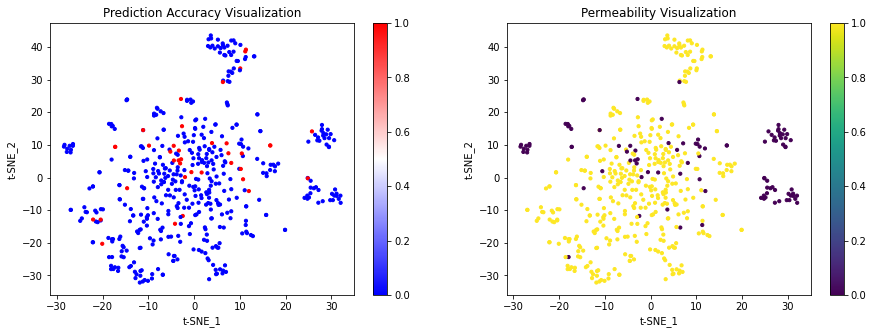

In [100]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(t_components[:,0], t_components[:,1], c=correct_pred, cmap='bwr', s=10)
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
plt.title('Prediction Accuracy Visualization')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(t_components[:,0], t_components[:,1], c=y_test,s=10)
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
plt.title('Permeability Visualization')
plt.colorbar()